Tar ofte utgangspunkt i latente modell / indeksvariabel som er kontinuerlig. 
$$
y^* = \mathbf{x}'\beta + \epsilon
$$
der $\epsilon \sim N(0,\sigma^2)$ og $y = g(y^*)$.

eksempler er 
- $y=I\{y^* \geq 0 \} $, probit
- $y = \begin{cases}
0, y^* \leq 0 \\
y^*, y^* > 0
\end{cases}
 = max(y^*,0)$, tobit

In [1]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.stats import norm

In [2]:
plt.rcParams["font.family"] = "serif"

### Binary

Konstruerer latent variabel explisitt og ser om vi kan gjenfinne parameter

In [3]:
N = 50
a,b = -.3,.8
X = np.c_[np.ones(N),np.random.uniform(a,b,size=N)]
β = [-0.5,2]
y_latent = X@β+np.random.normal(size=N)
y_obs = (y_latent > 0).astype(int)

x_grid = np.linspace(a,b)

får tilbake beta med større utvalg. Er kosnsistent altså. merk at store standardfeil.

In [4]:
mod_p = sm.Probit(y_obs,X).fit()
mod_l = sm.Logit(y_obs,X).fit()
mod_lin = sm.OLS(y_obs,X).fit()

Optimization terminated successfully.
         Current function value: 0.574309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574870
         Iterations 5


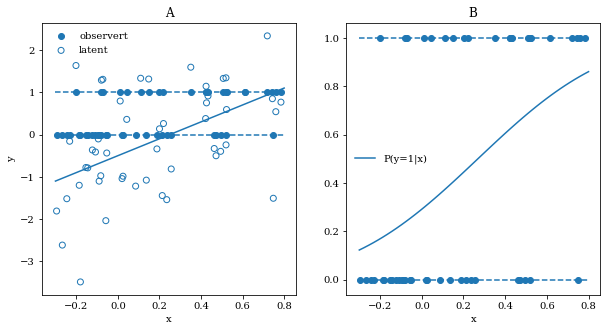

In [5]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10,5))
ax0.scatter(X[:,1],y_obs,label='observert')
ax0.scatter(X[:,1],y_latent,facecolor='none',edgecolors='tab:blue',label='latent')
ax0.plot(x_grid,β[0]+β[1]*x_grid)
ax0.legend(framealpha=0)
ax0.set(xlabel='x',ylabel='y')
ax0.hlines(0,a,b,linestyles='dashed',color='tab:blue')
ax0.hlines(1,a,b,linestyles='dashed',color='tab:blue')
ax0.title.set_text('A')

ax1.scatter(X[:,1],y_obs)
ax1.hlines(0,a,b,linestyles='dashed',color='tab:blue')
ax1.hlines(1,a,b,linestyles='dashed',color='tab:blue')

ax1.plot(x_grid,mod_p.predict(np.c_[np.ones(len(x_grid)),x_grid]),label='P(y=1|x)')
ax1.legend()
ax1.legend(framealpha=0,loc='center left')
ax1.set_xlabel('x')
ax1.title.set_text('B')

fig.savefig('probit.pdf')

### Tobit 

Bruker samme latent modell

In [6]:
y_obs = y_latent.copy()
y_obs[y_latent<0] = 0

Må implementere tobit sjæl. tror det er mulig å vektorisere på smarte måter meg jeg brute forcer

In [7]:
def log_like(θ):
    y = y_obs
    b = θ[:2]
    s = θ[-1]
    pos_idx = np.where(y>0)[0]
    neg_idx = np.where(y==0)[0]
    
    log_like = 0
    
    log_like += sum(np.log(1-norm().cdf(X[neg_idx]@b/s)))
    log_like += sum(np.log(1/s*norm().pdf((y[pos_idx]-X[pos_idx]@b)/s)))
    return -log_like

In [8]:
bounds = opt.Bounds((-np.inf,-np.inf,0),(np.inf,np.inf,np.inf))
res = opt.minimize(log_like,np.array([1,1,1]),bounds=bounds)
b_hat = res.x[:2]
sigma_hat = res.x[-1]
xb = b_hat[0]+b_hat[1]*x_grid
c = (b_hat[0]+b_hat[1]*x_grid)/sigma_hat

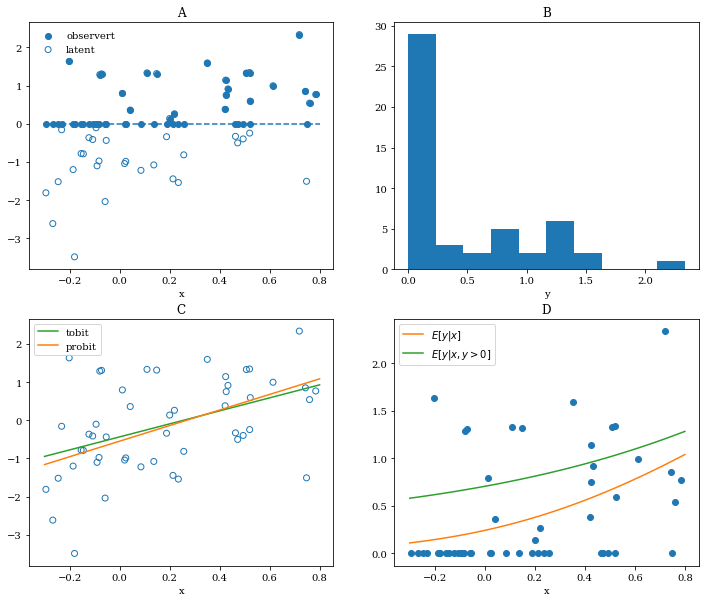

In [9]:
fig, axes = plt.subplots(2,2,figsize=(12,10))
(ax0,ax1,ax2,ax3) = axes.flatten()
ax0.scatter(X[:,1],y_obs,label='observert')
ax0.scatter(X[:,1],y_latent,facecolor='none',edgecolors='tab:blue',label='latent')
ax0.hlines(0,a,b,linestyles='dashed',color='tab:blue')
ax0.legend(framealpha=0)
ax0.set_xlabel('x')
ax0.title.set_text('A')

ax1.hist(y_obs)
ax1.set_xlabel('y')
ax1.title.set_text('B')

ax2.plot(x_grid,b_hat[0]+b_hat[1]*x_grid,color='tab:green',label='tobit')
ax2.plot(x_grid,mod_p.params[0]+mod_p.params[1]*x_grid,color='tab:orange',label='probit')
ax2.scatter(X[:,1],y_latent,facecolor='none',edgecolors='tab:blue')
ax2.legend()
ax2.set_xlabel('x')
ax2.title.set_text('C')

ax3.plot(x_grid, xb*norm().cdf(c)+sigma_hat*norm().pdf(c),color='tab:orange',label=r'$E[y|x]$')
ax3.plot(x_grid,xb+sigma_hat*(norm().pdf(c)/norm.cdf(c)),color='tab:green',label=r'$E[y|x,y>0]$')
ax3.scatter(X[:,1],y_obs,color='tab:blue')
ax3.legend()
ax3.set_xlabel('x')
ax3.title.set_text('D')

fig.savefig('tobit.pdf')

Litt vanskelig å plotte E[y|..] siden i utgangspunktet R^d+1->R. Kan plotte min special case, men det blir litt whacky

### Truncated